# UMAP Analysis of Canary Song Data

Canary song is incredibly rich, with canaries singing very stereotyped syllables that they learn from a tutor song. Canaries, along with zebra finches and bengalese finches, are a model organism for studying sensory-motor learning because of the homologies between the bird and mammal cortico-basal ganglia circuits. However, in order to understand the neural mechanisms of motor skill learning in canaries, one must understand canary behavior (song). Researchers generally identify structure in canary song by finding syllables, or a particular note the bird sings. However, this process of manually annotating syllables is incredibly time consuming. Is it possible to leverage modern machine learning to do syllable annotation for us? That is, can a machine learning algorithm identify the statistical similarities between the same syllable and also identify the statistical dissimilarities between different syllables? In more technical terms, we want to find a low-dimensional embedding of canary song that still maintains the topological relationships between syllables in high-dimensional space. In this notebook we will leverage UMAP (Uniform Manifold Approximation and Projection), an unsupervised way to find low-dimensional embeddings of high-dimensional data.

The data we will be working with is from Yarden Cohen, Tim Gardner, and colleagues from the following paper: https://doi.org/10.7554/eLife.63853. The data from 3 canaries can be found from the following link: https://datadryad.org/stash/dataset/doi:10.5061/dryad.xgxd254f4 . The dataset is a collection of spectrograms of canary song.

The basic premise of our analysis will be as follows:
1. Concatenate many spectrograms into one full spectrogram.
2. Take moving windows of the full spectrogram to create "mini-spectrograms"
3. Dimensionally reduce the mini-spectrograms using UMAP
4. Plot the projection of each mini-spectrogram into UMAP space
5. Identify clustering structure of similar syllables in UMAP space.

## Load Libraries and Set Up Parameters

The parameters we have control over as as follows:
1. num_spec : These are the number of spectrograms we will concatenate together
2. window_size (in pixels) : This is the mini-spectrogram size. This is a critical parameter. 
3. stride (in pixels): This specifies how much we want to move forward when creating each mini-spectrogram.

In [1]:
# Load libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import silhouette_score
import umap
from sklearn.decomposition import PCA
import warnings
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import pickle

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
warnings.filterwarnings("ignore")

# Set parameters
bird_dir = '/Users/ananyakapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/Users/ananyakapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis'

# Parameters we set
num_spec = 1
window_size = 100
stride = 10

# Define the folder name
folder_name = f'{analysis_path}/Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_name+"/Plots/Window_Plots"):
    os.makedirs(folder_name+"/Plots/Window_Plots")
    print(f'Folder "{folder_name}" created successfully.')
else:
    print(f'Folder "{folder_name}" already exists.')


/Users/ananyakapoor/opt/anaconda3/envs/Rotation_Gardner/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Folder "/Users/ananyakapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis/Num_Spectrograms_1_Window_Size_100_Stride_10" already exists.


## Preloading Results (If Applicable)

In [2]:
# =============================================================================
# # If you are loading the results from a previous analysis, run the following lines of code
# =============================================================================

stacked_windows = np.load(folder_name+'/stacked_windows.npy') # An array of all the mini-spectrograms
labels_for_window = np.load(folder_name+'/labels_for_window.npy') # The syllable labels for each time point in each mini-spectrogram
embedding = np.load(folder_name+'/UMAP_Embedding.npy') # The pre-computed UMAP embedding (2 dimensional)
masked_frequencies = np.load(analysis_path+'/masked_frequencies_lowthresh_500_highthresh_7000.npy') # The frequencies we want to use for analysis. Excluding unnecessarily low and high frequencies
stacked_window_times = np.load(folder_name+'/stacked_window_times.npy') # The onsets and ending of each mini-spectrogram
    
# open the file for reading in binary mode
with open(folder_name+'/category_colors.pkl', 'rb') as f:
    # load the dictionary from the file using pickle.load()
    category_colors = pickle.load(f)   
    
# Each syllable is given a unique color. Each mini-spectrogram will have an average syllable color associated with it. This is the average RGB value across all unique syllables in the mini-spectrogram
mean_colors_per_minispec = np.load(folder_name+'/mean_colors_per_minispec.npy')

## Extract the Data and Run a UMAP Analysis

Let's take a look at one spectrogram as an example.

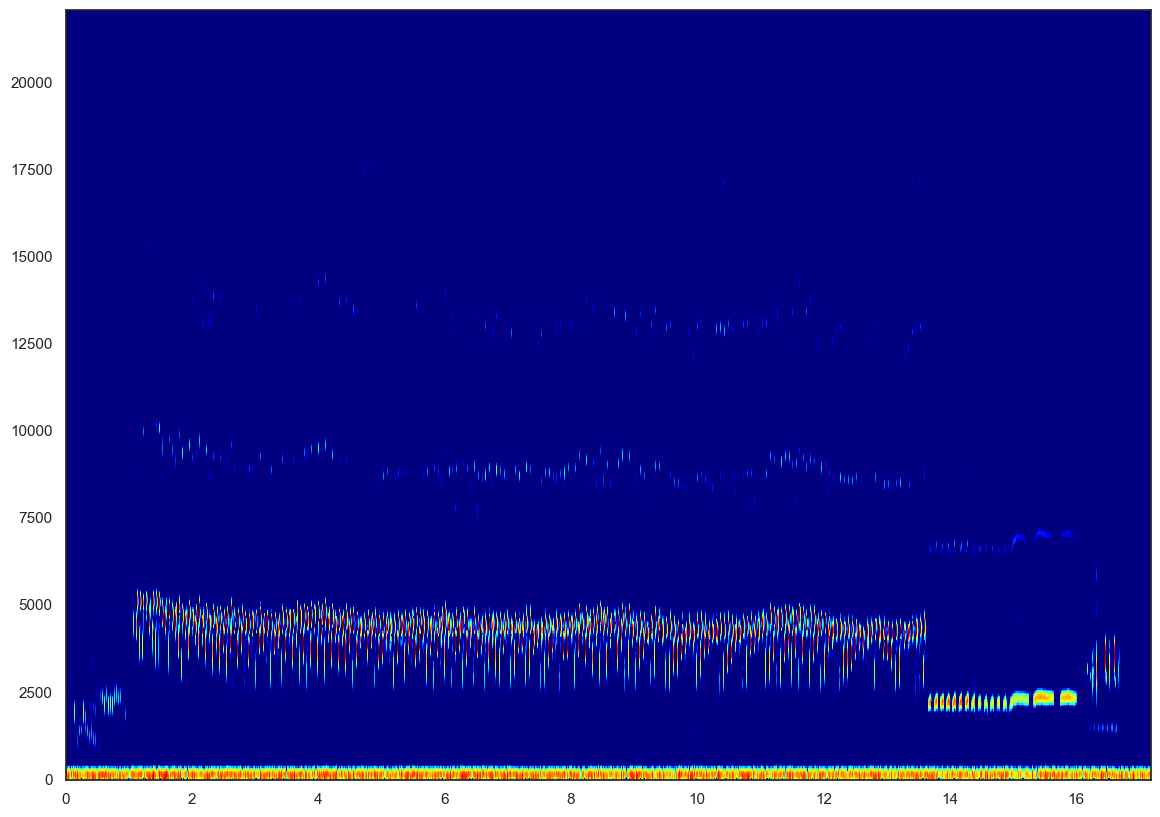

In [3]:
files = os.listdir(directory)
all_songs_data = [element for element in files if '.npz' in element] # Get the file paths of each numpy file from Yarden's data
all_songs_data.sort()
os.chdir(directory)

all_audio_data = os.listdir(audio_files)
all_audio_data.sort()
dat = np.load(all_songs_data[0])
spec = dat['s']
times = dat['t']
frequencies = dat['f']
labels = dat['labels']
labels = labels.T

plt.figure()
plt.pcolormesh(times, frequencies, spec, cmap='jet')


Let's hear the song for this spectrogram

In [4]:
import simpleaudio as sa

# Define the WAV file to be played
filename = audio_files+'/'+all_audio_data[1]

# Load the WAV file
wave_obj = sa.WaveObject.from_wave_file(filename)

# Play the WAV file
play_obj = wave_obj.play()

# Wait for the WAV file to finish playing
play_obj.wait_done()

In [5]:
# =============================================================================
# # If you're running the analysis for the first time 
# =============================================================================

files = os.listdir(directory)
all_songs_data = [element for element in files if '.npz' in element] # Get the file paths of each numpy file from Yarden's data
all_songs_data.sort()
os.chdir(directory)

# For each spectrogram we will extract
# 1. Each timepoint's syllable label
# 2. The spectrogram itself
stacked_labels = [] 
stacked_specs = []
for i in np.arange(num_spec):
    # Extract the data within the numpy file. We will use this to create the spectrogram
    dat = np.load(all_songs_data[i])
    spec = dat['s']
    times = dat['t']
    frequencies = dat['f']
    labels = dat['labels']
    labels = labels.T


    # Let's get rid of higher order frequencies
    mask = (frequencies<7000)&(frequencies>500)
    masked_frequencies = frequencies[mask]

    subsetted_spec = spec[mask.reshape(mask.shape[0],),:]
    
    stacked_labels.append(labels)
    stacked_specs.append(subsetted_spec)

    
stacked_specs = np.concatenate((stacked_specs), axis = 1)
stacked_labels = np.concatenate((stacked_labels), axis = 0)

# Get a list of unique categories (syllable labels)
unique_categories = np.unique(stacked_labels)

# Create a dictionary that maps categories to random colors
category_colors = {category: np.random.rand(3,) for category in unique_categories}

spec_for_analysis = stacked_specs.T
window_labels_arr = []
embedding_arr = []
# Find the exact sampling frequency (the time in miliseconds between one pixel [timepoint] and another pixel)
dx = np.diff(times)[0,0]

# We will now extract each mini-spectrogram from the full spectrogram
stacked_windows = []
# Find the syllable labels for each mini-spectrogram
stacked_labels_for_window = []
# Find the mini-spectrograms onset and ending times 
stacked_window_times = []

# The below for-loop will find each mini-spectrogram (window) and populate the empty lists we defined above.
for i in range(0, spec_for_analysis.shape[0] - window_size + 1, stride):
    # Find the window
    window = spec_for_analysis[i:i + window_size, :]
    # Get the window onset and ending times
    window_times = dx*np.arange(i, i + window_size)
    # We will flatten the window to be a 1D vector
    window = window.reshape(1, window.shape[0]*window.shape[1])
    # Extract the syllable labels for the window
    labels_for_window = stacked_labels[i:i+window_size, :]
    # Reshape the syllable labels for the window into a 1D array
    labels_for_window = labels_for_window.reshape(1, labels_for_window.shape[0]*labels_for_window.shape[1])
    # Populate the empty lists defined above
    stacked_windows.append(window)
    stacked_labels_for_window.append(labels_for_window)
    stacked_window_times.append(window_times)

# Convert the populated lists into a stacked numpy array
stacked_windows = np.stack(stacked_windows, axis = 0)
stacked_windows = np.squeeze(stacked_windows)

stacked_labels_for_window = np.stack(stacked_labels_for_window, axis = 0)
stacked_labels_for_window = np.squeeze(stacked_labels_for_window)

stacked_window_times = np.stack(stacked_window_times, axis = 0)

# For each mini-spectrogram, find the average color across all unique syllables
mean_colors_per_minispec = np.zeros((stacked_labels_for_window.shape[0], 3))
for i in np.arange(stacked_labels_for_window.shape[0]):
    list_of_colors_for_row = [category_colors[x] for x in stacked_labels_for_window[i,:]]
    all_colors_in_minispec = np.array(list_of_colors_for_row)
    mean_color = np.mean(all_colors_in_minispec, axis = 0)
    mean_colors_per_minispec[i,:] = mean_color
    
# Perform a UMAP embedding on the dataset of mini-spectrograms
reducer = umap.UMAP()
embedding = reducer.fit_transform(stacked_windows)

# Let's save all the numpy arrays
np.save(folder_name+'/stacked_windows.npy', stacked_windows)
np.save(folder_name+'/labels_for_window.npy', labels_for_window)
np.save(folder_name+'/UMAP_Embedding.npy', embedding)
np.save(analysis_path+'/masked_frequencies_lowthresh_500_highthresh_7000.npy', masked_frequencies)
np.save(folder_name+'/stacked_window_times.npy', stacked_window_times)
np.save(folder_name+'/mean_colors_per_minispec.npy', mean_colors_per_minispec)

# open a file for writing in binary mode
with open(folder_name+'/category_colors.pkl', 'wb') as f:
    # write the dictionary to the file using pickle.dump()
    pickle.dump(category_colors, f)

# The below function will save an image for each mini-spectrogram. This will be used for understanding the UMAP plot.
def embeddable_image(data, window_times, iteration_number):
    
    data.shape = (window_size, int(data.shape[0]/window_size))
    data = data.T 
    window_times = window_times.reshape(1, window_times.shape[0])
    plt.pcolormesh(window_times, masked_frequencies, data, cmap='jet')
    # let's save the plt colormesh as an image.
    plt.savefig(folder_name+'/Plots/Window_Plots/'+f'Window_{iteration_number}.png')
    plt.close()
    
    
for i in np.arange(stacked_windows.shape[0]):
    if i%10 == 0:
        print(f'Iteration {i} of {stacked_windows.shape[0]}')
    data = stacked_windows[i,:]
    window_times = stacked_window_times[i,:]
    embeddable_image(data, window_times, i)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Iteration 0 of 628
Iteration 10 of 628
Iteration 20 of 628
Iteration 30 of 628
Iteration 40 of 628
Iteration 50 of 628
Iteration 60 of 628
Iteration 70 of 628
Iteration 80 of 628
Iteration 90 of 628
Iteration 100 of 628
Iteration 110 of 628
Iteration 120 of 628
Iteration 130 of 628
Iteration 140 of 628
Iteration 150 of 628
Iteration 160 of 628
Iteration 170 of 628
Iteration 180 of 628
Iteration 190 of 628
Iteration 200 of 628
Iteration 210 of 628
Iteration 220 of 628
Iteration 230 of 628
Iteration 240 of 628
Iteration 250 of 628
Iteration 260 of 628
Iteration 270 of 628
Iteration 280 of 628
Iteration 290 of 628
Iteration 300 of 628
Iteration 310 of 628
Iteration 320 of 628
Iteration 330 of 628
Iteration 340 of 628
Iteration 350 of 628
Iteration 360 of 628
Iteration 370 of 628
Iteration 380 of 628
Iteration 390 of 628
Iteration 400 of 628
Iteration 410 of 628
Iteration 420 of 628
Iteration 430 of 628
Iteration 440 of 628
Iteration 450 of 628
Iteration 460 of 628
Iteration 470 of 628
Ite

## Plot the UMAP Embedding

We will use the Bokeh library for interactive plotting

In [6]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{folder_name}/Plots/umap.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding[:,0], y = embedding[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)

save(p)


'/Users/ananyakapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis/Num_Spectrograms_1_Window_Size_100_Stride_10/Plots/umap.html'

The UMAP embedding isn't perfect. There are some mini-spectrograms that are clumped with very dissimilar syllables. The next step would be to try different embedding procedures that use deep learning methods. 

## Plot an Animation of the Song's Trajectory

The UMAP embedding is useful for visualizing the structure of similar and disparate mini-spectrograms. However, what does the trajectory of mini-spectrograms look like over time? Can we identify transition structures from syllable to syllable? The below code creates this animation. Note: the visualization here is pretty crude and will be updated in the near future. Also the animation speed is painfully slow on Jupyter Notebooks for some reason.

In [10]:
%matplotlib tk
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

x = embedding[:,0]
y = embedding[:,1]

fig = plt.figure()
plt.xlim(np.min(x)-5, np.max(x)+5)
plt.ylim(np.min(y)-5, np.max(y)+5)


# Generate an array of colors for each point
colors = mean_colors_per_minispec

graph = plt.scatter([], [], marker='o', c=[])

def animate(i):
    if i > x.shape[0]-1:
        i = x.shape[0]-1
        
    # Update the data and colors for the points that have already been plotted
    graph.set_offsets(np.vstack((x[:i+1], y[:i+1])).T)
    graph.set_color(colors[:i+1])
    
    # Plot the new point with its color
    graph.axes.scatter(x[i], y[i], color=colors[i])
    
    return graph,

ani = FuncAnimation(fig, animate, interval=500)

plt.show()